# Analyse des séries temporelles avec Python

Ce notebook couvre les fondamentaux de l'analyse de séries temporelles : génération de données synthétiques, visualisation, tests de stationnarité, autocorrélation, décomposition, bruit blanc, random walk, méthodes de stationnarisation, modélisation ARMA, sélection de modèles, diagnostics et exercices pratiques.

## 1. Importer les bibliothèques nécessaires

Nous allons utiliser numpy, pandas, matplotlib, seaborn, statsmodels, scipy, sklearn, et configurer les options d'affichage pour l'analyse des séries temporelles.

In [2]:
# Installation des bibliothèques nécessaires
!pip install numpy pandas matplotlib seaborn scipy statsmodels scikit-learn


  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB 487.6 kB/s eta 0:00:20
   ---------------------------------------- 0.1/9.6 MB 563.7 kB/s eta 0:00:17
   ---------------------------------------- 0.1/9.6 MB 563.7 kB/s eta 0:00:17
    --------------------------------------- 0.2/9.6 MB 654.6 kB/s eta 0:00:15
    --------------------------------------- 0.2/9.6 MB 846.9 kB/s eta 0:00:12
   - 


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import des bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Bibliothèques statistiques
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import LinearRegression
import itertools

# Configuration de l'affichage
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

print("Bibliothèques importées avec succès !")

Bibliothèques importées avec succès !


## 2. Générer une série temporelle synthétique avec toutes les composantes

Nous allons créer une série temporelle synthétique composée d'une tendance, d'une saisonnalité et d'un bruit aléatoire. Chaque composante sera visualisée séparément pour bien comprendre leur rôle.

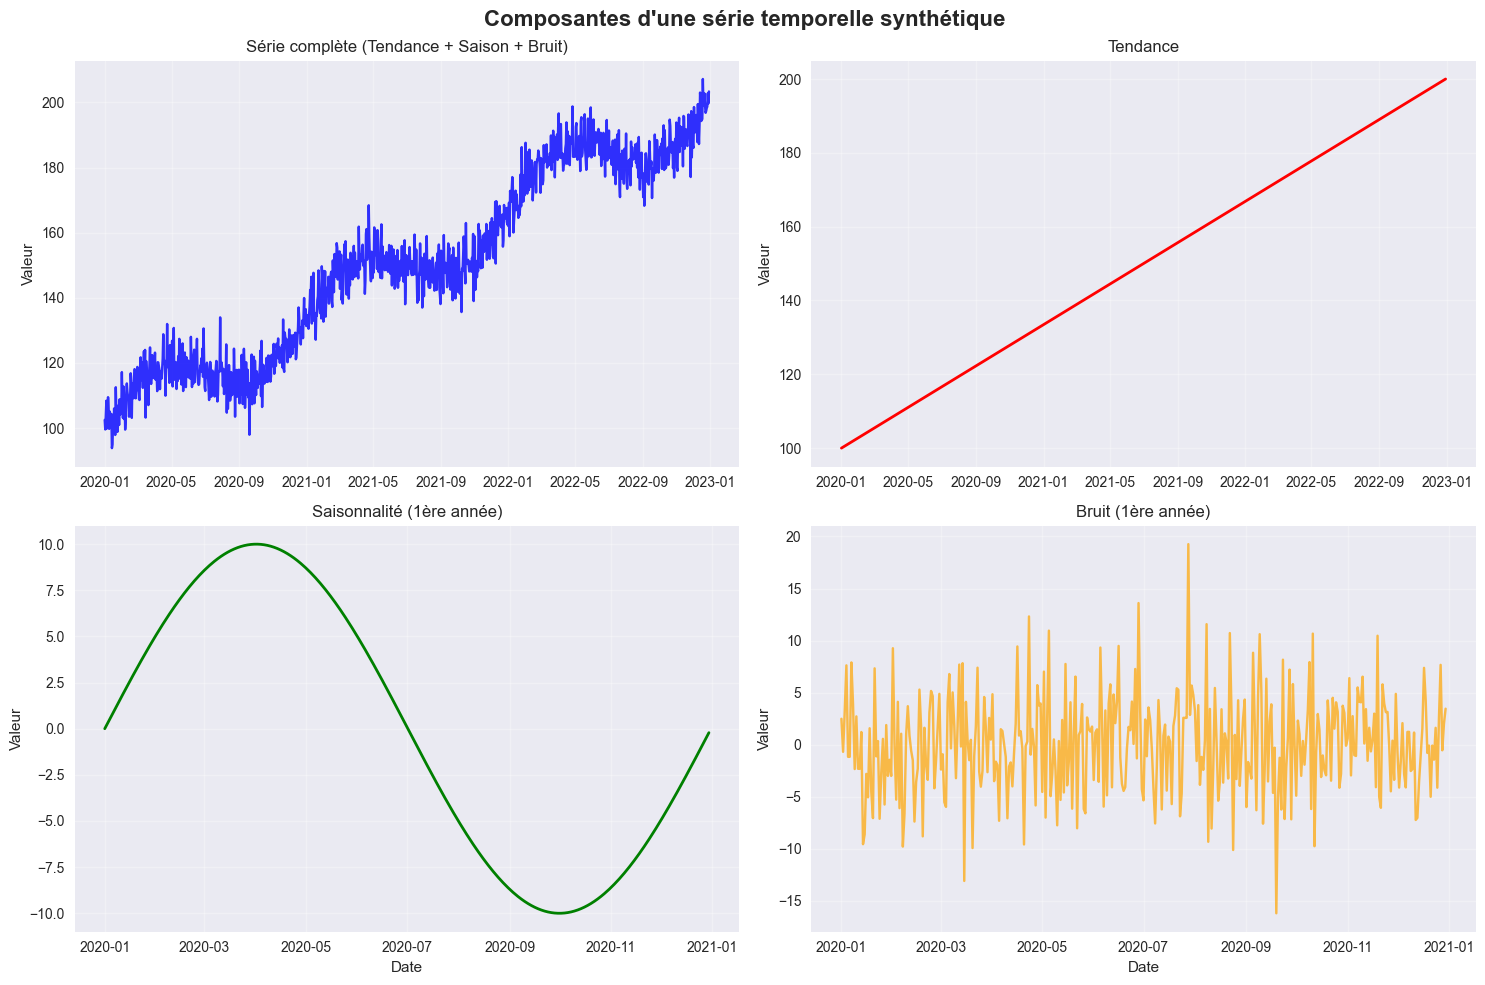

Série générée : 1095 points sur 3.0 années


In [4]:
# Génération d'une série temporelle synthétique
np.random.seed(42)
dates = pd.date_range('2020-01-01', periods=365*3, freq='D')
n = len(dates)

# Composantes
trend = np.linspace(100, 200, n)  # Tendance linéaire
seasonal = 10 * np.sin(2 * np.pi * np.arange(n) / 365.25)  # Saison annuel
noise = np.random.normal(0, 5, n)  # Bruit blanc

# Série complète (modèle additif)
ts_data = trend + seasonal + noise

df = pd.DataFrame({
    'date': dates,
    'value': ts_data,
    'trend': trend,
    'seasonal': seasonal,
    'noise': noise
})

# Visualisation des composantes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Composantes d\'une série temporelle synthétique', fontsize=16, fontweight='bold')

axes[0, 0].plot(df['date'], df['value'], color='blue', alpha=0.8)
axes[0, 0].set_title('Série complète (Tendance + Saison + Bruit)')
axes[0, 0].set_ylabel('Valeur')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(df['date'], df['trend'], color='red', linewidth=2)
axes[0, 1].set_title('Tendance')
axes[0, 1].set_ylabel('Valeur')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(df['date'][:365], df['seasonal'][:365], color='green', linewidth=2)
axes[1, 0].set_title('Saisonnalité (1ère année)')
axes[1, 0].set_ylabel('Valeur')
axes[1, 0].set_xlabel('Date')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(df['date'][:365], df['noise'][:365], color='orange', alpha=0.7)
axes[1, 1].set_title('Bruit (1ère année)')
axes[1, 1].set_ylabel('Valeur')
axes[1, 1].set_xlabel('Date')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Série générée : {n} points sur {n/365.25:.1f} années")

## 3. Tester la stationnarité avec le test ADF

La stationnarité est essentielle pour la modélisation des séries temporelles. Nous allons définir une fonction pour appliquer le test de Dickey-Fuller augmenté (ADF) et interpréter les résultats sur la série synthétique et sa version détrendée.

In [5]:
# Fonction pour appliquer le test de Dickey-Fuller augmenté (ADF)
def check_stationarity(timeseries, title):
    """
    Applique le test ADF et affiche l'interprétation
    H0 : la série est non stationnaire (racine unitaire)
    H1 : la série est stationnaire
    """
    print(f'\n{"="*50}')
    print(f'Test de stationnarité ADF pour : {title}')
    print(f'{"="*50}')
    result = adfuller(timeseries, autolag='AIC')
    print(f'Statistique ADF : {result[0]:.6f}')
    print(f'p-value : {result[1]:.6f}')
    print('Valeurs critiques :')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    if result[1] <= 0.05:
        print("\n✅ Résultat : STATIONNAIRE (on rejette H0)")
    else:
        print("\n❌ Résultat : NON STATIONNAIRE (on ne rejette pas H0)")

# Test sur la série synthétique
check_stationarity(df['value'], 'Série synthétique (avec tendance)')

# Détrending : on retire la tendance
stationary_data = df['value'] - df['trend']
check_stationarity(stationary_data, 'Série détrendée (sans tendance)')


Test de stationnarité ADF pour : Série synthétique (avec tendance)
Statistique ADF : -0.322002
p-value : 0.922330
Valeurs critiques :
  1%: -3.436
  5%: -2.864
  10%: -2.568

❌ Résultat : NON STATIONNAIRE (on ne rejette pas H0)

Test de stationnarité ADF pour : Série détrendée (sans tendance)
Statistique ADF : -1.866184
p-value : 0.348133
Valeurs critiques :
  1%: -3.436
  5%: -2.864
  10%: -2.568

❌ Résultat : NON STATIONNAIRE (on ne rejette pas H0)


## 4. Analyse de l'autocorrélation et de la corrélation partielle

Nous allons tracer l'ACF et la PACF sur la série originale et la série détrendée, puis calculer manuellement quelques autocorrélations pour illustrer leur interprétation.

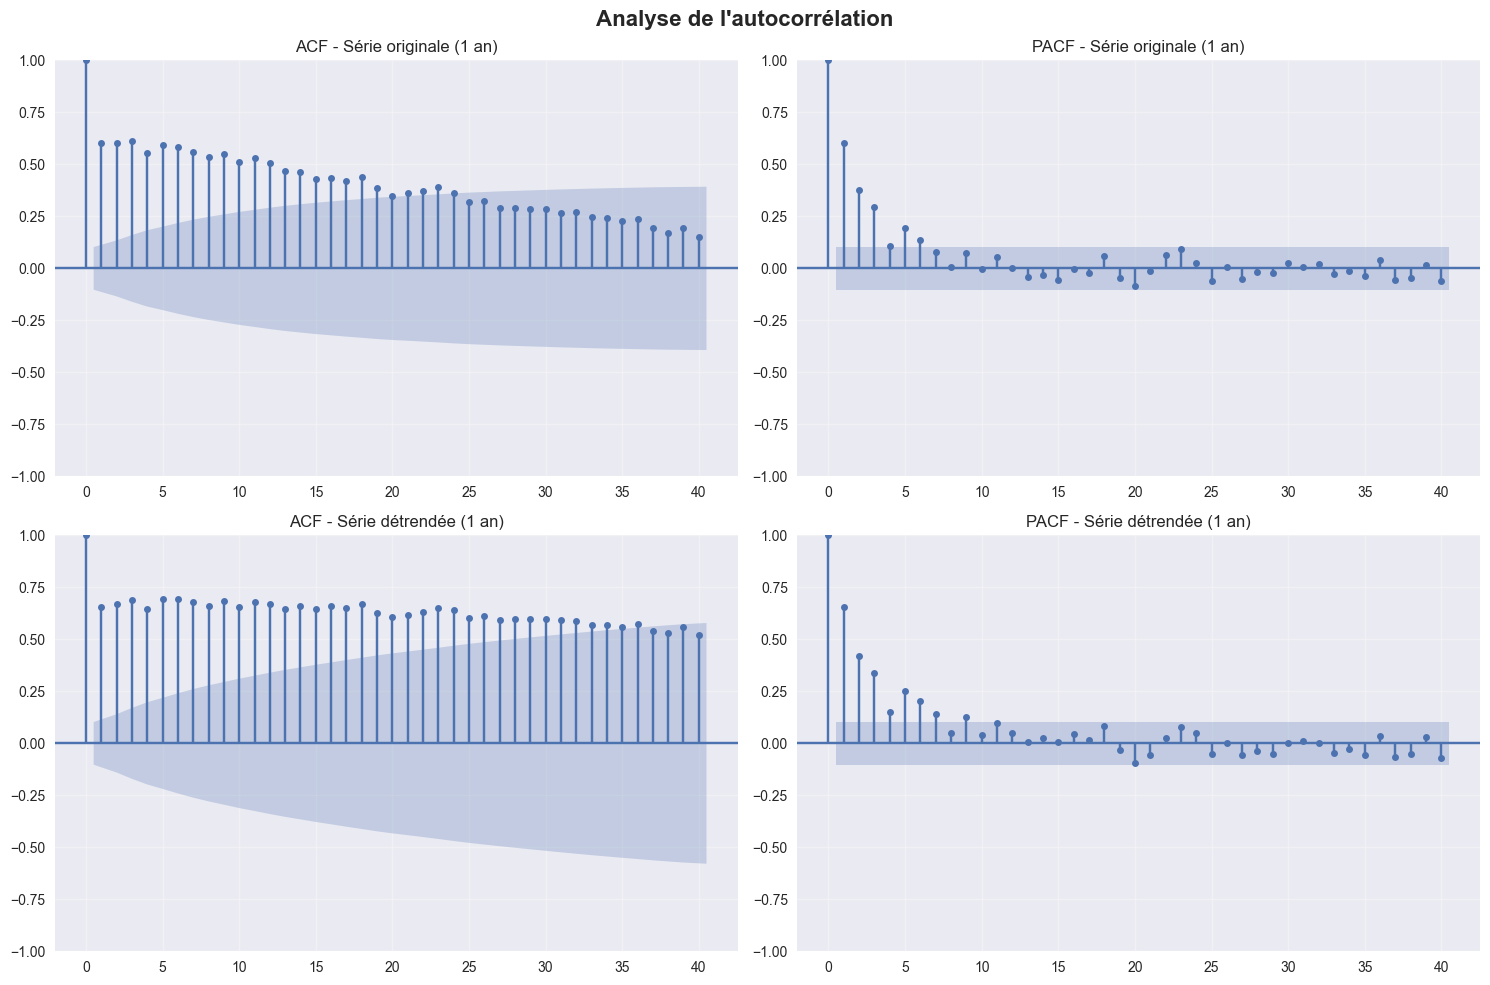


Calcul manuel de l'autocorrélation (100 premiers points de la série détrendée) :
Décalage  1 : ρ(1) =  0.3322
Décalage  2 : ρ(2) =  0.3129
Décalage  5 : ρ(5) =  0.4798
Décalage 10 : ρ(10) =  0.2839


In [6]:
# Tracé de l'ACF et de la PACF pour la série originale et détrendée
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Analyse de l'autocorrélation", fontsize=16, fontweight='bold')

# Série originale
plot_acf(df['value'][:365], ax=axes[0, 0], lags=40, title='ACF - Série originale (1 an)')
axes[0, 0].grid(True, alpha=0.3)
plot_pacf(df['value'][:365], ax=axes[0, 1], lags=40, title='PACF - Série originale (1 an)')
axes[0, 1].grid(True, alpha=0.3)

# Série détrendée
plot_acf(stationary_data[:365], ax=axes[1, 0], lags=40, title='ACF - Série détrendée (1 an)')
axes[1, 0].grid(True, alpha=0.3)
plot_pacf(stationary_data[:365], ax=axes[1, 1], lags=40, title='PACF - Série détrendée (1 an)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcul manuel de quelques autocorrélations
print("\nCalcul manuel de l'autocorrélation (100 premiers points de la série détrendée) :")
data_sample = stationary_data[:100]
for lag in [1, 2, 5, 10]:
    corr = np.corrcoef(data_sample[:-lag], data_sample[lag:])[0, 1]
    print(f"Décalage {lag:2d} : ρ({lag}) = {corr:7.4f}")

## 5. Décomposition de séries temporelles

La décomposition permet de séparer une série temporelle en tendance, saisonnalité et résidu. Nous allons utiliser la fonction `seasonal_decompose` pour réaliser une décomposition additive et multiplicative, puis comparer la qualité des résidus.

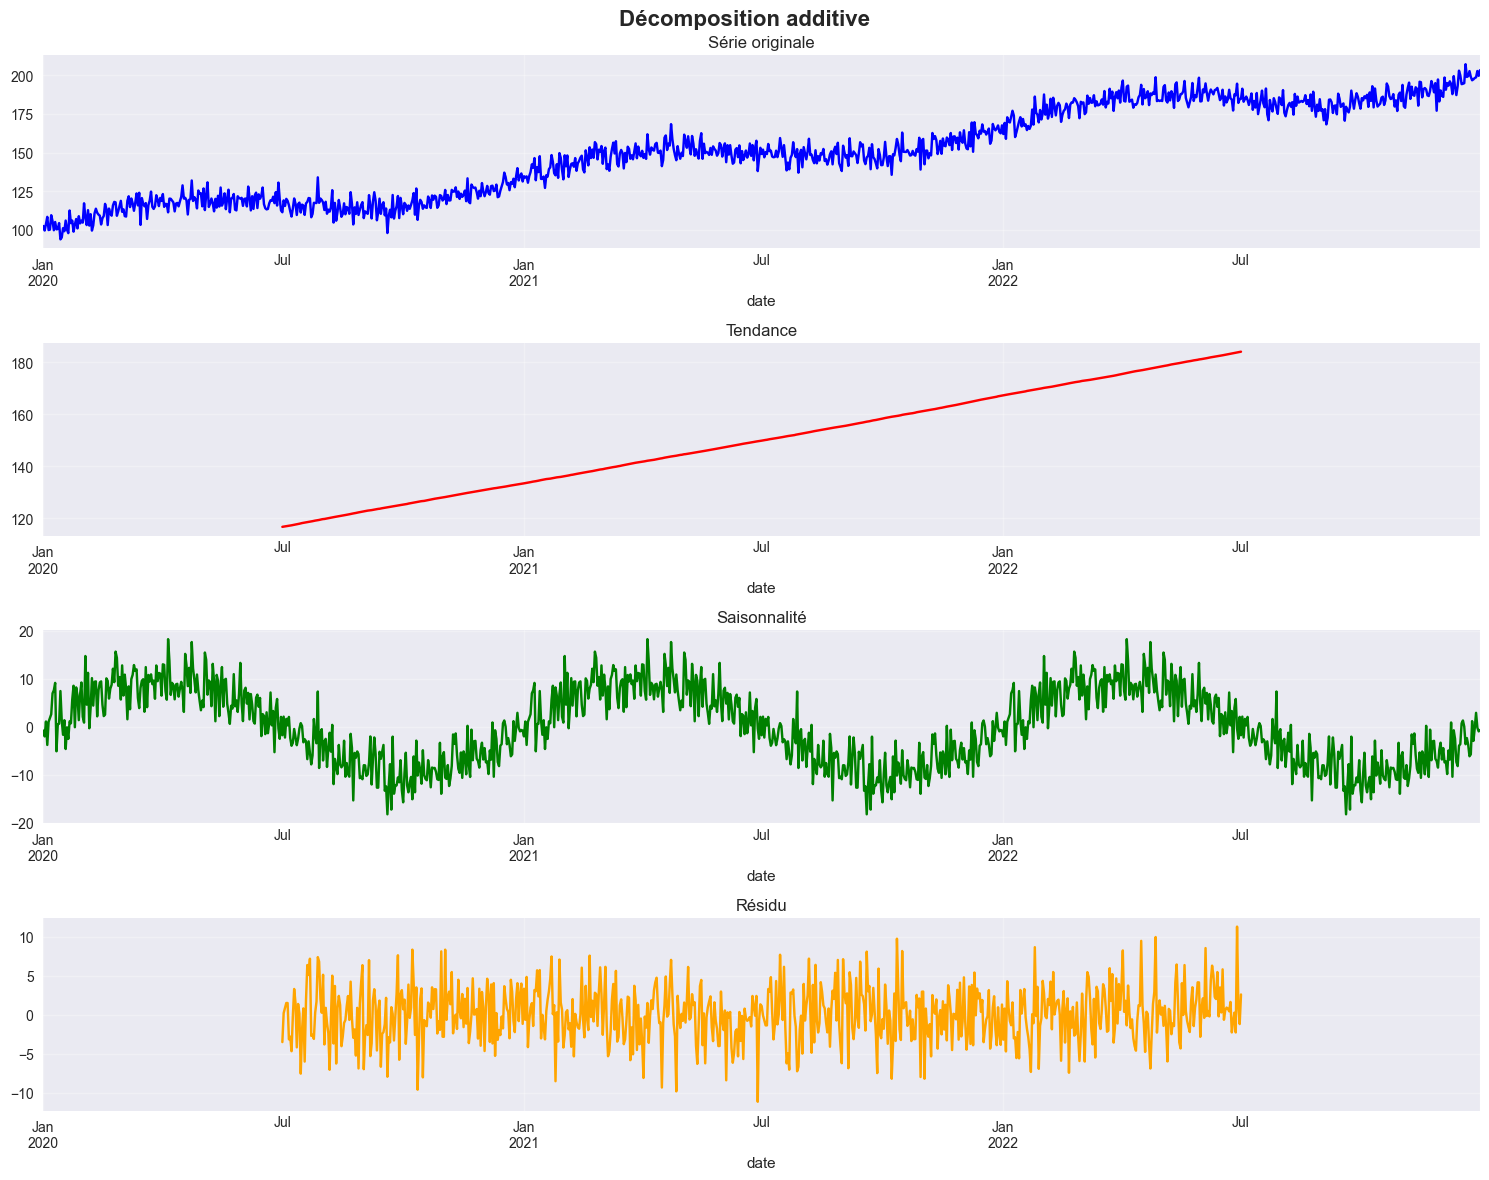


Comparaison de la variance des résidus :
Résidu additif : 3.4762
Résidu multiplicatif : 0.0247

✅ Le modèle multiplicatif est plus adapté (résidu plus faible)


In [7]:
# Décomposition de la série temporelle
serie = pd.Series(df['value'].values, index=df['date'])

# Décomposition additive
decomp_add = seasonal_decompose(serie, model='additive', period=365)
# Décomposition multiplicative
decomp_mult = seasonal_decompose(serie, model='multiplicative', period=365)

# Affichage de la décomposition additive
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.suptitle('Décomposition additive', fontsize=16, fontweight='bold')
decomp_add.observed.plot(ax=axes[0], title='Série originale', color='blue')
axes[0].grid(True, alpha=0.3)
decomp_add.trend.plot(ax=axes[1], title='Tendance', color='red')
axes[1].grid(True, alpha=0.3)
decomp_add.seasonal.plot(ax=axes[2], title='Saisonnalité', color='green')
axes[2].grid(True, alpha=0.3)
decomp_add.resid.plot(ax=axes[3], title='Résidu', color='orange')
axes[3].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Comparaison de la qualité des résidus
print("\nComparaison de la variance des résidus :")
add_std = decomp_add.resid.std()
mult_std = decomp_mult.resid.std()
print(f"Résidu additif : {add_std:.4f}")
print(f"Résidu multiplicatif : {mult_std:.4f}")
if add_std < mult_std:
    print("\n✅ Le modèle additif est plus adapté (résidu plus faible)")
else:
    print("\n✅ Le modèle multiplicatif est plus adapté (résidu plus faible)")

## 6. Simulation et comparaison : bruit blanc vs marche aléatoire

Nous allons simuler un bruit blanc, une marche aléatoire simple et une marche aléatoire avec dérive, comparer graphiquement et statistiquement, puis tester la stationnarité de chaque processus.

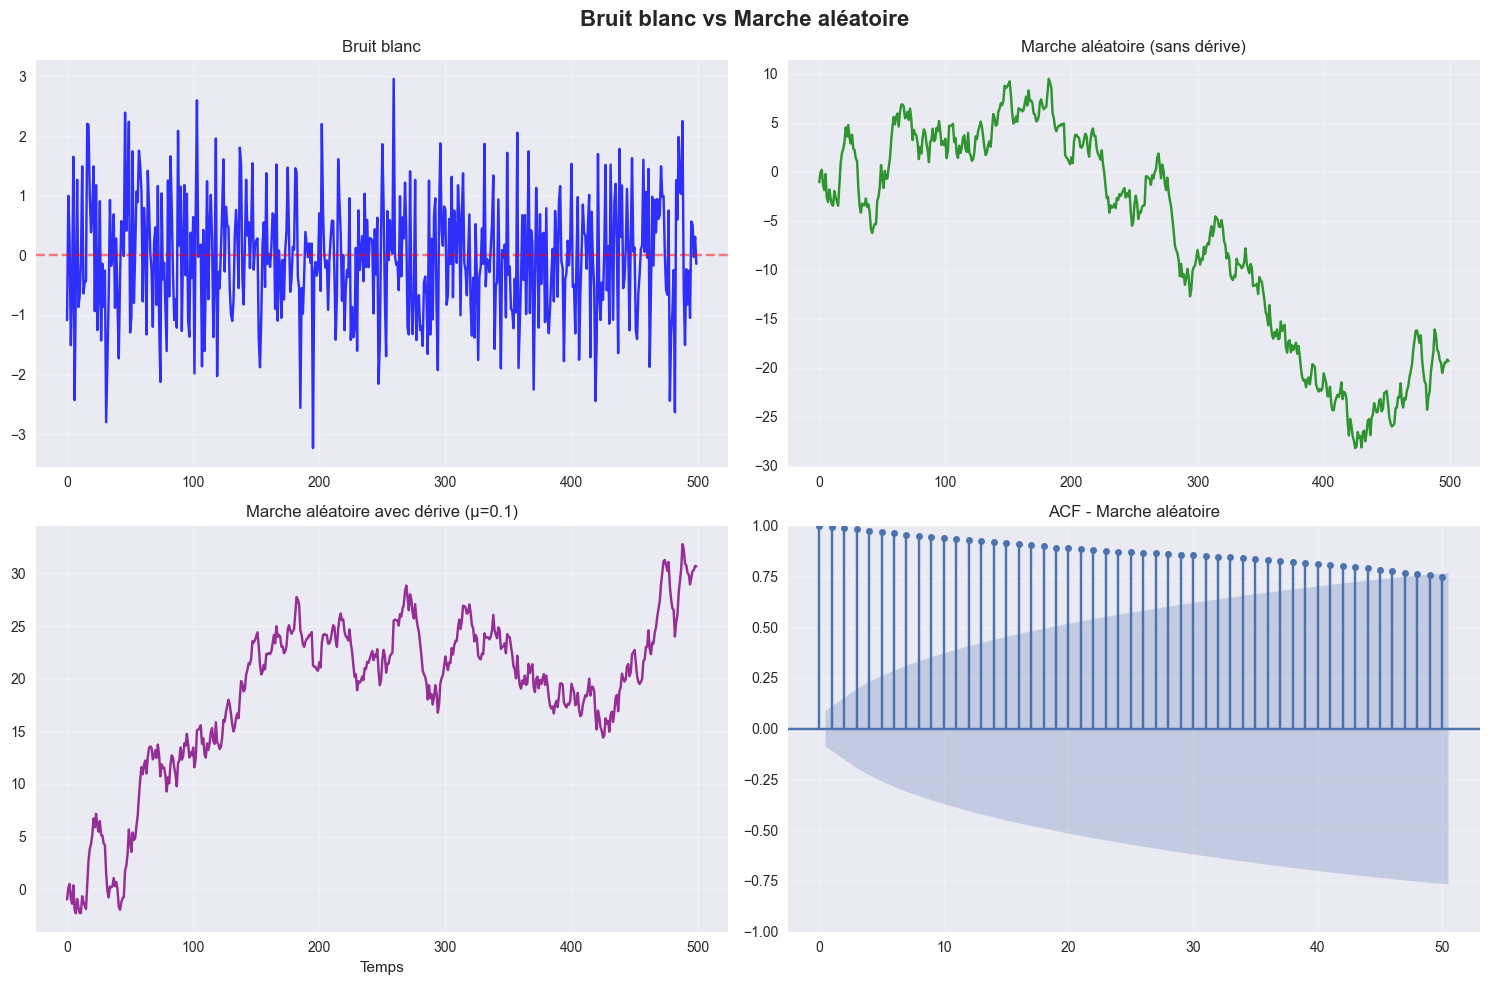

Comparaison statistique :
Processus                 Moyenne    Écart-type   Min        Max       
Bruit blanc               -0.039     1.003        -3.231     2.959     
Marche aléatoire          -6.470     10.852       -28.203    9.465     
Marche aléatoire + drift  18.580     7.624        -2.294     32.793    

Test de stationnarité ADF pour : Bruit blanc
Statistique ADF : -21.643970
p-value : 0.000000
Valeurs critiques :
  1%: -3.444
  5%: -2.867
  10%: -2.570

✅ Résultat : STATIONNAIRE (on rejette H0)

Test de stationnarité ADF pour : Marche aléatoire
Statistique ADF : -0.751057
p-value : 0.833078
Valeurs critiques :
  1%: -3.444
  5%: -2.867
  10%: -2.570

❌ Résultat : NON STATIONNAIRE (on ne rejette pas H0)


In [8]:
# Simulation bruit blanc et marches aléatoires
np.random.seed(123)
n_sim = 500
t = np.arange(n_sim)

# Bruit blanc
white_noise = np.random.normal(0, 1, n_sim)
# Marche aléatoire sans dérive
random_walk = np.cumsum(white_noise)
# Marche aléatoire avec dérive
mu = 0.1
random_walk_drift = np.cumsum(white_noise + mu)

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Bruit blanc vs Marche aléatoire', fontsize=16, fontweight='bold')
axes[0, 0].plot(t, white_noise, color='blue', alpha=0.8)
axes[0, 0].set_title('Bruit blanc')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].plot(t, random_walk, color='green', alpha=0.8)
axes[0, 1].set_title('Marche aléatoire (sans dérive)')
axes[0, 1].grid(True, alpha=0.3)
axes[1, 0].plot(t, random_walk_drift, color='purple', alpha=0.8)
axes[1, 0].set_title(f'Marche aléatoire avec dérive (μ={mu})')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlabel('Temps')
plot_acf(random_walk, ax=axes[1, 1], lags=50, title='ACF - Marche aléatoire')
axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques descriptives
print("Comparaison statistique :")
print(f"{'Processus':<25} {'Moyenne':<10} {'Écart-type':<12} {'Min':<10} {'Max':<10}")
print(f"{'Bruit blanc':<25} {np.mean(white_noise):<10.3f} {np.std(white_noise):<12.3f} {np.min(white_noise):<10.3f} {np.max(white_noise):<10.3f}")
print(f"{'Marche aléatoire':<25} {np.mean(random_walk):<10.3f} {np.std(random_walk):<12.3f} {np.min(random_walk):<10.3f} {np.max(random_walk):<10.3f}")
print(f"{'Marche aléatoire + drift':<25} {np.mean(random_walk_drift):<10.3f} {np.std(random_walk_drift):<12.3f} {np.min(random_walk_drift):<10.3f} {np.max(random_walk_drift):<10.3f}")

# Tests de stationnarité
check_stationarity(white_noise, 'Bruit blanc')
check_stationarity(random_walk, 'Marche aléatoire')

## 7. Méthodes pour rendre une série stationnaire

Nous allons appliquer et visualiser différentes méthodes pour rendre une série non stationnaire stationnaire : différenciation simple, transformation logarithmique, différenciation saisonnière, détrendage par régression linéaire. Nous testerons la stationnarité de chaque transformation.

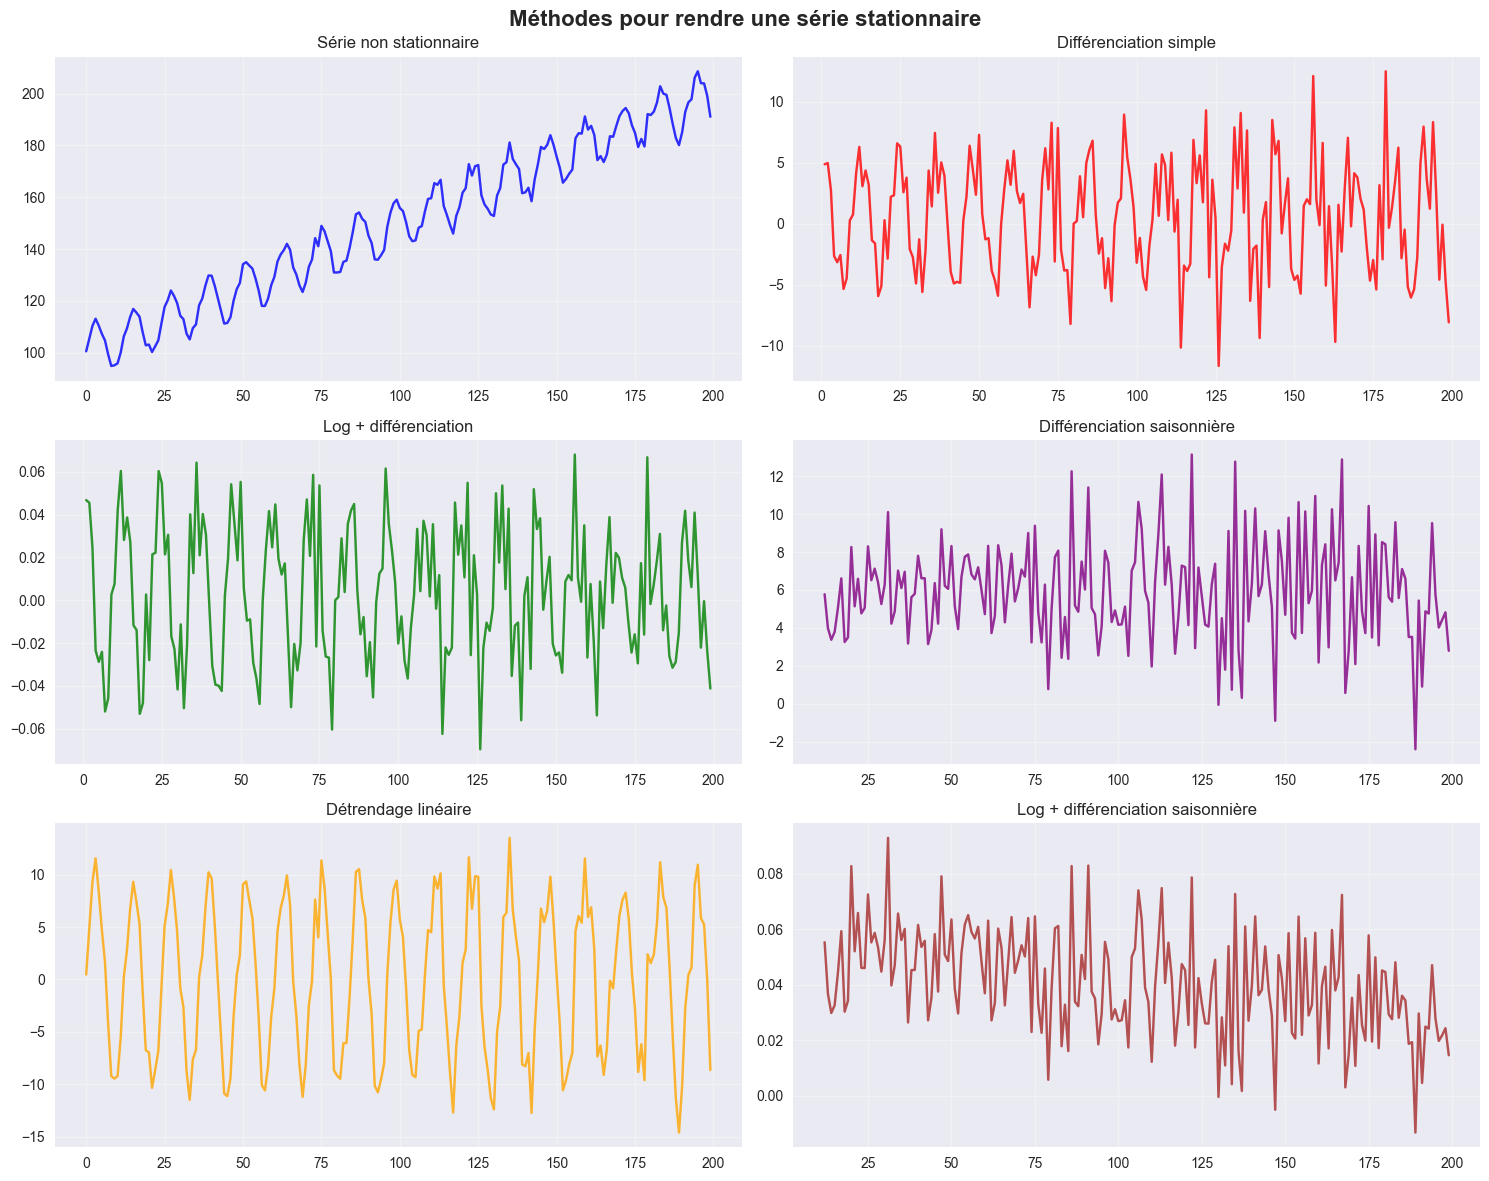


Test de stationnarité ADF pour : Série originale
Statistique ADF : -0.388048
p-value : 0.912075
Valeurs critiques :
  1%: -3.466
  5%: -2.877
  10%: -2.575

❌ Résultat : NON STATIONNAIRE (on ne rejette pas H0)

Test de stationnarité ADF pour : Différenciation simple
Statistique ADF : -12.136795
p-value : 0.000000
Valeurs critiques :
  1%: -3.466
  5%: -2.877
  10%: -2.575

✅ Résultat : STATIONNAIRE (on rejette H0)

Test de stationnarité ADF pour : Log + différenciation
Statistique ADF : -3.186915
p-value : 0.020755
Valeurs critiques :
  1%: -3.467
  5%: -2.877
  10%: -2.575

✅ Résultat : STATIONNAIRE (on rejette H0)

Test de stationnarité ADF pour : Différenciation saisonnière
Statistique ADF : -5.628892
p-value : 0.000001
Valeurs critiques :
  1%: -3.468
  5%: -2.878
  10%: -2.576

✅ Résultat : STATIONNAIRE (on rejette H0)

Test de stationnarité ADF pour : Détrendage linéaire
Statistique ADF : -2.803611
p-value : 0.057760
Valeurs critiques :
  1%: -3.466
  5%: -2.877
  10%: -2.575

❌

In [9]:
# Création d'une série non stationnaire avec tendance et variance croissante
np.random.seed(42)
t = np.arange(200)
trend = 0.5 * t
seasonal = 10 * np.sin(2 * np.pi * t / 12)
noise = np.random.normal(0, 1 + 0.01*t, 200)
non_stationary = 100 + trend + seasonal + noise

# 1. Différenciation simple
first_diff = np.diff(non_stationary)
# 2. Log puis différenciation
log_data = np.log(non_stationary + 1)
log_diff = np.diff(log_data)
# 3. Différenciation saisonnière (période 12)
seasonal_diff = non_stationary[12:] - non_stationary[:-12]
# 4. Détrendage par régression linéaire
X = t.reshape(-1, 1)
reg = LinearRegression().fit(X, non_stationary)
detrended = non_stationary - reg.predict(X)
# 5. Log + différenciation saisonnière
log_seasonal_diff = log_data[12:] - log_data[:-12]

# Visualisation
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Méthodes pour rendre une série stationnaire', fontsize=16, fontweight='bold')
axes[0, 0].plot(t, non_stationary, color='blue', alpha=0.8)
axes[0, 0].set_title('Série non stationnaire')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 1].plot(t[1:], first_diff, color='red', alpha=0.8)
axes[0, 1].set_title('Différenciation simple')
axes[0, 1].grid(True, alpha=0.3)
axes[1, 0].plot(t[1:], log_diff, color='green', alpha=0.8)
axes[1, 0].set_title('Log + différenciation')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 1].plot(t[12:], seasonal_diff, color='purple', alpha=0.8)
axes[1, 1].set_title('Différenciation saisonnière')
axes[1, 1].grid(True, alpha=0.3)
axes[2, 0].plot(t, detrended, color='orange', alpha=0.8)
axes[2, 0].set_title('Détrendage linéaire')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 1].plot(t[12:], log_seasonal_diff, color='brown', alpha=0.8)
axes[2, 1].set_title('Log + différenciation saisonnière')
axes[2, 1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Tests de stationnarité
transformations = [
    (non_stationary, 'Série originale'),
    (first_diff, 'Différenciation simple'),
    (log_diff, 'Log + différenciation'),
    (seasonal_diff, 'Différenciation saisonnière'),
    (detrended, 'Détrendage linéaire')
]
for data, name in transformations:
    check_stationarity(data, name)

## 8. Modélisation AR, MA, ARMA et analyse

Nous allons simuler des processus AR(2), MA(2), ARMA(1,1), tracer les séries, ACF, PACF, et vérifier la stationnarité et les propriétés empiriques de chaque modèle.

### Fondements mathématiques : Génération d'une série temporelle synthétique

Une série temporelle peut être modélisée comme la somme de plusieurs composantes :

- **Tendance (T_t)** : évolution lente du niveau moyen, souvent modélisée par une fonction linéaire ou polynomiale.
- **Saisonnalité (S_t)** : variations périodiques, modélisées par des fonctions trigonométriques (ex : sinus/cosinus).
- **Bruit (I_t)** : composante aléatoire, souvent supposée gaussienne.

**Modèle additif :**

$$Y_t = T_t + S_t + I_t$$

**Modèle multiplicatif :**

$$Y_t = T_t \times S_t \times I_t$$

### Fondements mathématiques : Test de stationnarité ADF

Le test de Dickey-Fuller augmenté (ADF) vérifie la présence d'une racine unitaire dans une série temporelle, c'est-à-dire si la série est non stationnaire.

**Modèle testé :**

$$
\Delta Y_t = \alpha + \beta t + \gamma Y_{t-1} + \sum_{i=1}^p \phi_i \Delta Y_{t-i} + \varepsilon_t
$$

- $\Delta Y_t = Y_t - Y_{t-1}$ (différence première)
- $\gamma$ : paramètre clé. H0 : $\gamma = 0$ (non stationnaire), H1 : $\gamma < 0$ (stationnaire)

On rejette H0 si la statistique ADF est inférieure à la valeur critique (p-value < 0.05).

### Fondements mathématiques : ACF et PACF

- **ACF (Autocorrelation Function)** : mesure la corrélation entre $Y_t$ et $Y_{t-h}$ pour différents lags $h$.

$$
\rho(h) = \frac{\mathrm{Cov}(Y_t, Y_{t-h})}{\mathrm{Var}(Y_t)}
$$

- **PACF (Partial Autocorrelation Function)** : mesure la corrélation directe entre $Y_t$ et $Y_{t-h}$ en retirant l'effet des lags intermédiaires.

L'ACF et la PACF sont essentielles pour identifier l'ordre des modèles AR et MA.

### Fondements mathématiques : Décomposition de séries temporelles

La décomposition sépare une série $Y_t$ en :
- **Tendance (T_t)** : évolution lente
- **Saisonnalité (S_t)** : motif périodique
- **Résidu (R_t)** : bruit

**Modèle additif :**
$$Y_t = T_t + S_t + R_t$$

**Modèle multiplicatif :**
$$Y_t = T_t \times S_t \times R_t$$

La décomposition permet d'analyser séparément chaque composante.

### Fondements mathématiques : Bruit blanc et marche aléatoire

- **Bruit blanc** : $\varepsilon_t \sim \mathcal{N}(0, \sigma^2)$, i.i.d., $\mathbb{E}[\varepsilon_t]=0$, $\mathrm{Var}(\varepsilon_t)=\sigma^2$, pas d'autocorrélation.

- **Marche aléatoire** :
$$Y_t = Y_{t-1} + \varepsilon_t$$

- **Marche aléatoire avec dérive** :
$$Y_t = \mu + Y_{t-1} + \varepsilon_t$$

La marche aléatoire est non stationnaire (variance croissante avec le temps).

### Fondements mathématiques : Méthodes pour rendre une série stationnaire

- **Différenciation** : $\nabla Y_t = Y_t - Y_{t-1}$
- **Différenciation saisonnière** : $\nabla_s Y_t = Y_t - Y_{t-s}$
- **Transformation logarithmique** : $Z_t = \ln(Y_t)$
- **Décomposition/détrendage** : $Y_t = \alpha + \beta t + \varepsilon_t$ (on retire la tendance estimée)

Ces méthodes visent à stabiliser la moyenne et la variance de la série.

### Fondements mathématiques : Modèles AR, MA, ARMA

- **AR(p) :**
$$Y_t = \phi_1 Y_{t-1} + \dots + \phi_p Y_{t-p} + \varepsilon_t$$

- **MA(q) :**
$$Y_t = \varepsilon_t + \theta_1 \varepsilon_{t-1} + \dots + \theta_q \varepsilon_{t-q}$$

- **ARMA(p,q) :**
$$Y_t = \phi_1 Y_{t-1} + \dots + \phi_p Y_{t-p} + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \dots + \theta_q \varepsilon_{t-q}$$

Ces modèles permettent de capturer la dépendance temporelle dans les séries stationnaires.

### Fondements mathématiques : Critères de sélection de modèle et diagnostics

- **AIC** : $AIC = -2 \ln(L) + 2k$
- **BIC** : $BIC = -2 \ln(L) + k \ln(n)$
- **HQIC** : $HQIC = -2 \ln(L) + 2k \ln(\ln(n))$

Où $L$ est la vraisemblance maximale, $k$ le nombre de paramètres, $n$ la taille de l'échantillon.

- **Test de Ljung-Box** :
$$Q = n(n+2) \sum_{h=1}^H \frac{\hat{\rho}^2(h)}{n-h}$$

Permet de tester l'absence d'autocorrélation dans les résidus du modèle.